In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
import logging
from sklearn.preprocessing import LabelEncoder,StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import cross_validate,KFold,train_test_split,StratifiedKFold
from sklearn.metrics import log_loss,f1_score,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from prettytable import PrettyTable
import time

pd.set_option('display.max_columns',100)
%matplotlib inline
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(logging.CRITICAL + 1)

In [36]:
#Reading the data 
train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
real = pd.read_csv("/kaggle/input/churnmodeling/Churn_Modelling.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [37]:
test_id = test['id']
#Removing unnecesary columns
real.drop(columns=['RowNumber'],inplace=True)
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
#joining the training datasets
train = pd.concat([train,real]).reset_index(drop=True)

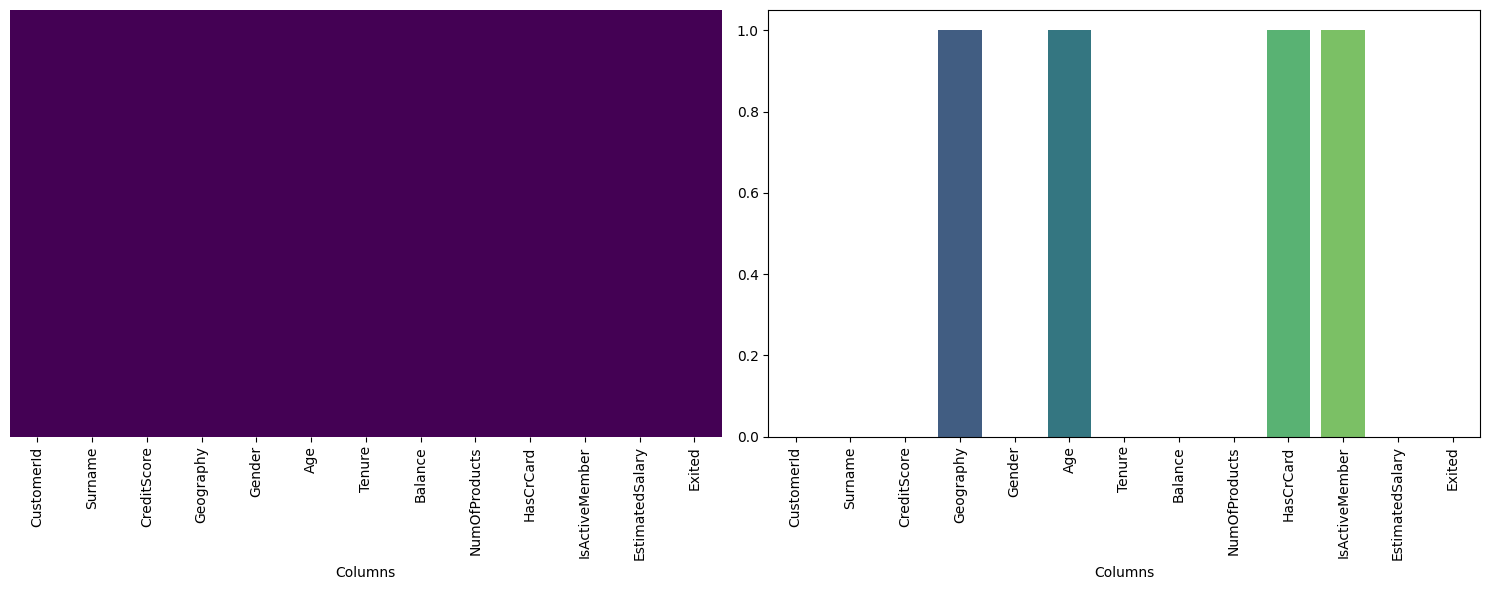

In [38]:
#looking for null values
def NullValues(df):
    '''
    This function looks for the null values in a data frame and return a heatmap indicating the null values and a barplot showing the number of missing values
    '''
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
    sns.heatmap(data=df.isnull(),yticklabels=False,ax=axes[0],cbar=False,cmap='viridis')
    sns.barplot(x=df.columns,y=df.isnull().sum(),ax=axes[1],palette='viridis')
    axes[1].set_xticklabels(labels= axes[1].get_xticklabels(), rotation=90)
    axes[1].set_xlabel("Columns")
    axes[0].set_xlabel("Columns")
    plt.tight_layout()
    plt.show()
    
NullValues(train)


In [39]:
#dropping the null values
train.dropna(inplace=True)

In [40]:
#OneHotEncoding the Geography column
train[['France','Germany','Spain']]  = pd.get_dummies(train['Geography']).astype('int64')
test[['France','Germany','Spain']]  = pd.get_dummies(test['Geography']).astype('int64')

In [41]:
train.drop(columns=['Geography'],inplace=True)

In [42]:
#Label encoding the gender
label_encoder = LabelEncoder()
label_cols = ['Gender']
for i in label_cols:
    train[i]  = label_encoder.fit_transform(train[i])
    test[i] = label_encoder.transform(test[i])

In [43]:
#OneHotEncoding the NumOfProducts
train[['OneProduct','TwoProducts','ThreeProducts','FourProducts']] = pd.get_dummies(train['NumOfProducts']).astype('int64')
test[['OneProduct','TwoProducts','ThreeProducts','FourProducts']] = pd.get_dummies(test['NumOfProducts']).astype('int64')

In [44]:
#Based on balance EDA people with zero balance are less likely to churn and people with balance 100k - 150k have higher chance to churn 
train['ZeroBalance'] = train['Balance'].apply(lambda x : 1 if x == 0 else 0)
test['ZeroBalance'] = test['Balance'].apply(lambda x : 1 if x == 0 else 0)

train['Balance(100-150k)'] = train['Balance'].apply(lambda x : 1 if x >= 10000 and x<=150000 else 0)
test['Balance(100-150k)'] = test['Balance'].apply(lambda x : 1 if x >= 10000 and x<=150000 else 0)

In [45]:
#Splitting the age feature into 3 groups. Based of the EDA people from 35-70 have a higher chance to churn 
train['Age(30-70)'] = train['Age'].apply(lambda x: 1 if x<=70 and x>=35 else 0)
test['Age(30-70)'] = test['Age'].apply(lambda x: 1 if x<=70 and x>=35 else 0)

train['Age(less30)'] = train['Age'].apply(lambda x: 1 if x<30 else 0)
test['Age(less30)'] = test['Age'].apply(lambda x: 1 if x<30 else 0)

train['Age(greater70)'] = train['Age'].apply(lambda x: 1 if x>70 else 0)
test['Age(greater70)'] = test['Age'].apply(lambda x: 1 if x>70 else 0)

In [46]:
train.head()

,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,OneProduct,TwoProducts,ThreeProducts,FourProducts,ZeroBalance,Balance(100-150k),Age(30-70),Age(less30),Age(greater70)
0,15674932,Okwudilichukwu,668,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1,0,0,1,0,0,0,0
1,15749177,Okwudiliolisa,627,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1,0,0,1,0,0,0,0
2,15694510,Hsueh,678,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1,0,0,1,0,1,0,0
3,15741417,Kao,581,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0,1,0,0,0,0,1,0,0,0
4,15766172,Chiemenam,716,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1,0,0,1,0,0,0,0


In [47]:
test.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,OneProduct,TwoProducts,ThreeProducts,FourProducts,ZeroBalance,Balance(100-150k),Age(30-70),Age(less30),Age(greater70)
0,15773898,Lucchese,586,France,0,23.0,2,0.00,2,0.0,1.0,160976.75,1,0,0,0,1,0,0,1,0,0,1,0
1,15782418,Nott,683,France,0,46.0,2,0.00,1,1.0,0.0,72549.27,1,0,0,1,0,0,0,1,0,1,0,0
2,15807120,K?,656,France,0,34.0,7,0.00,2,1.0,0.0,138882.09,1,0,0,0,1,0,0,1,0,0,0,0
3,15808905,O'Donnell,681,France,1,36.0,8,0.00,1,1.0,0.0,113931.57,1,0,0,1,0,0,0,1,0,1,0,0
4,15607314,Higgins,752,Germany,1,38.0,10,121263.62,1,1.0,0.0,139431.00,0,1,0,1,0,0,0,0,1,1,0,0


In [48]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
for c in scale_cols:
    min_value = train[c].min()
    max_value = train[c].max()
    train[c+"_scaled"] = (train[c] - min_value) / (max_value - min_value)
    test[c+"_scaled"] = (test[c] - min_value) / (max_value - min_value)

In [49]:
train.head()

,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,OneProduct,TwoProducts,ThreeProducts,FourProducts,ZeroBalance,Balance(100-150k),Age(30-70),Age(less30),Age(greater70),Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled
0,15674932,Okwudilichukwu,668,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1,0,0,1,0,0,0,0,0.202703,0.636,0.000000,0.907279
1,15749177,Okwudiliolisa,627,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1,0,0,1,0,0,0,0,0.202703,0.554,0.000000,0.247483
2,15694510,Hsueh,678,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1,0,0,1,0,1,0,0,0.297297,0.656,0.000000,0.924364
3,15741417,Kao,581,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0,1,0,0,0,0,1,0,0,0,0.216216,0.462,0.593398,0.422787
4,15766172,Chiemenam,716,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1,0,0,1,0,0,0,0,0.202703,0.732,0.000000,0.075293


In [50]:
test.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,OneProduct,TwoProducts,ThreeProducts,FourProducts,ZeroBalance,Balance(100-150k),Age(30-70),Age(less30),Age(greater70),Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled
0,15773898,Lucchese,586,France,0,23.0,2,0.00,2,0.0,1.0,160976.75,1,0,0,0,1,0,0,1,0,0,1,0,0.067568,0.472,0.000000,0.804903
1,15782418,Nott,683,France,0,46.0,2,0.00,1,1.0,0.0,72549.27,1,0,0,1,0,0,0,1,0,1,0,0,0.378378,0.666,0.000000,0.362723
2,15807120,K?,656,France,0,34.0,7,0.00,2,1.0,0.0,138882.09,1,0,0,0,1,0,0,1,0,0,0,0,0.216216,0.612,0.000000,0.694419
3,15808905,O'Donnell,681,France,1,36.0,8,0.00,1,1.0,0.0,113931.57,1,0,0,1,0,0,0,1,0,1,0,0,0.243243,0.662,0.000000,0.569654
4,15607314,Higgins,752,Germany,1,38.0,10,121263.62,1,1.0,0.0,139431.00,0,1,0,1,0,0,0,0,1,1,0,0,0.270270,0.804,0.483318,0.697164


In [51]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    
    
    return df

In [52]:
df_train = getFeats(train)
df_test = getFeats(test)

In [53]:
df_train.head()

,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,OneProduct,TwoProducts,ThreeProducts,FourProducts,ZeroBalance,Balance(100-150k),Age(30-70),Age(less30),Age(greater70),Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure
0,15674932,Okwudilichukwu,668,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1,0,0,1,0,0,0,0,0.202703,0.636,0.000000,0.907279,0,0.0,1.5
1,15749177,Okwudiliolisa,627,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1,0,0,1,0,0,0,0,0.202703,0.554,0.000000,0.247483,0,1.0,0.5
2,15694510,Hsueh,678,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1,0,0,1,0,1,0,0,0.297297,0.656,0.000000,0.924364,0,0.0,5.0
3,15741417,Kao,581,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0,1,0,0,0,0,1,0,0,0,0.216216,0.462,0.593398,0.422787,0,1.0,2.0
4,15766172,Chiemenam,716,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1,0,0,1,0,0,0,0,0.202703,0.732,0.000000,0.075293,0,1.0,2.5


In [54]:
df_test.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,OneProduct,TwoProducts,ThreeProducts,FourProducts,ZeroBalance,Balance(100-150k),Age(30-70),Age(less30),Age(greater70),Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure
0,15773898,Lucchese,586,France,0,23.0,2,0.00,2,0.0,1.0,160976.75,1,0,0,0,1,0,0,1,0,0,1,0,0.067568,0.472,0.000000,0.804903,0,0.0,1.0
1,15782418,Nott,683,France,0,46.0,2,0.00,1,1.0,0.0,72549.27,1,0,0,1,0,0,0,1,0,1,0,0,0.378378,0.666,0.000000,0.362723,0,0.0,2.0
2,15807120,K?,656,France,0,34.0,7,0.00,2,1.0,0.0,138882.09,1,0,0,0,1,0,0,1,0,0,0,0,0.216216,0.612,0.000000,0.694419,0,0.0,3.5
3,15808905,O'Donnell,681,France,1,36.0,8,0.00,1,1.0,0.0,113931.57,1,0,0,1,0,0,0,1,0,1,0,0,0.243243,0.662,0.000000,0.569654,0,0.0,8.0
4,15607314,Higgins,752,Germany,1,38.0,10,121263.62,1,1.0,0.0,139431.00,0,1,0,1,0,0,0,0,1,1,0,0,0.270270,0.804,0.483318,0.697164,0,0.0,10.0


In [55]:
#All the columns 
df_train.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'France', 'Germany', 'Spain', 'OneProduct',
       'TwoProducts', 'ThreeProducts', 'FourProducts', 'ZeroBalance',
       'Balance(100-150k)', 'Age(30-70)', 'Age(less30)', 'Age(greater70)',
       'Age_scaled', 'CreditScore_scaled', 'Balance_scaled',
       'EstimatedSalary_scaled', 'IsSenior', 'IsActive_by_CreditCard',
       'Products_Per_Tenure'],
      dtype='object')

In [56]:
df_test.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'France', 'Germany', 'Spain', 'OneProduct',
       'TwoProducts', 'ThreeProducts', 'FourProducts', 'ZeroBalance',
       'Balance(100-150k)', 'Age(30-70)', 'Age(less30)', 'Age(greater70)',
       'Age_scaled', 'CreditScore_scaled', 'Balance_scaled',
       'EstimatedSalary_scaled', 'IsSenior', 'IsActive_by_CreditCard',
       'Products_Per_Tenure'],
      dtype='object')

In [57]:
df_train.drop(columns=['Surname'],inplace=True)
df_test.drop(columns=['Surname'],inplace=True)

In [84]:
df_train.drop(columns=['Age(greater70)'],inplace=True)
df_test.drop(columns=['Age(greater70)'],inplace=True)

In [85]:
df_train.columns

Index(['CustomerId', 'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'France', 'Germany', 'Spain', 'OneProduct', 'TwoProducts',
       'ThreeProducts', 'FourProducts', 'ZeroBalance', 'Balance(100-150k)',
       'Age(30-70)', 'Age(less30)', 'Age_scaled', 'CreditScore_scaled',
       'Balance_scaled', 'EstimatedSalary_scaled', 'IsSenior',
       'IsActive_by_CreditCard', 'Products_Per_Tenure'],
      dtype='object')

In [111]:
df_test.columns

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'France', 'Germany', 'Spain', 'OneProduct',
       'TwoProducts', 'ThreeProducts', 'FourProducts', 'ZeroBalance',
       'Balance(100-150k)', 'Age(30-70)', 'Age(less30)', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure'],
      dtype='object')

In [86]:
feat_cols=df_train.columns.drop(['Exited'])
feat_cols=feat_cols.drop(scale_cols)
print(feat_cols)
df_train.head()

Index(['CustomerId', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'France', 'Germany', 'Spain', 'OneProduct',
       'TwoProducts', 'ThreeProducts', 'FourProducts', 'ZeroBalance',
       'Balance(100-150k)', 'Age(30-70)', 'Age(less30)', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure'],
      dtype='object')


,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,OneProduct,TwoProducts,ThreeProducts,FourProducts,ZeroBalance,Balance(100-150k),Age(30-70),Age(less30),Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure
0,15674932,668,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1,0,0,1,0,0,0,0.202703,0.636,0.000000,0.907279,0,0.0,1.5
1,15749177,627,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1,0,0,1,0,0,0,0.202703,0.554,0.000000,0.247483,0,1.0,0.5
2,15694510,678,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1,0,0,1,0,1,0,0.297297,0.656,0.000000,0.924364,0,0.0,5.0
3,15741417,581,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0,1,0,0,0,0,1,0,0,0.216216,0.462,0.593398,0.422787,0,1.0,2.0
4,15766172,716,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1,0,0,1,0,0,0,0.202703,0.732,0.000000,0.075293,0,1.0,2.5


In [87]:
final_cols = ['CustomerId', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'France', 'Germany', 'Spain', 'OneProduct',
       'TwoProducts', 'ThreeProducts', 'FourProducts', 'ZeroBalance',
       'Balance(100-150k)', 'Age(30-70)', 'Age(less30)',
       'Age_scaled', 'CreditScore_scaled', 'Balance_scaled',
       'EstimatedSalary_scaled', 'IsSenior', 'IsActive_by_CreditCard',
       'Products_Per_Tenure']

In [88]:
X=df_train[feat_cols]
y=df_train['Exited']

In [89]:
#Making a cross validation
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [90]:
def CrossValidate(clf,X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    scores = PrettyTable()
    scores.field_names = ['Fold','Accuracy','Roc_auc','Confusion Matrix','time to train']
    conf_matrices = []
    accuracies = []
    roc_auc_scores = []
    training_times = []
    for  train_index, test_index in kf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        start = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        conf_matrices.append(confusion_matrix(y_test, y_pred))
        accuracies.append(round(accuracy_score(y_test, y_pred),5))
        roc_auc_scores.append(round(roc_auc_score(y_test, y_prob),5))
        end = time.time()
        training_times.append(round(end-start,2))

    for i in range(10):
        scores.add_row([(i+1),accuracies[i],roc_auc_scores[i],conf_matrices[i],training_times[i]])

    print(scores)
    print(f"Mean accuracy - {sum(accuracies) / 10}")
    print(f"Mean roc_auc - {sum(roc_auc_scores) / 10}") 

In [91]:
def FeatureImp(model):
    fi = model.feature_importances_
    sorted_idx = np.argsort(fi).tolist()
    plt.figure(figsize=(8,8))
    plt.barh(range(len(sorted_idx)), fi[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [final_cols[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

In [92]:
#Using optuna we got these hyper parameters
lgbm_best_params = {'num_leaves': 100,
 'learning_rate': 0.07895324521843525,
 'feature_fraction': 0.5658166490064884,
 'bagging_fraction': 0.4307596104050439,
 'reg_alpha': 0.0740870606923929,
 'reg_lambda': 2.6993567325444864e-06,
 'min_child_samples': 10,
                   'verbose':-1}

In [93]:
lgbm = LGBMClassifier(**lgbm_best_params)

In [94]:
CrossValidate(lgbm,X,y)

[LightGBM] [Warning] feature_fraction is set=0.5658166490064884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5658166490064884
[LightGBM] [Warning] bagging_fraction is set=0.4307596104050439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4307596104050439
[LightGBM] [Warning] feature_fraction is set=0.5658166490064884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5658166490064884
[LightGBM] [Warning] bagging_fraction is set=0.4307596104050439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4307596104050439
[LightGBM] [Warning] feature_fraction is set=0.5658166490064884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5658166490064884
[LightGBM] [Warning] bagging_fraction is set=0.4307596104050439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4307596104050439
[LightGBM] [Warning] feature_fraction is set=0.5658166490064884, colsample_bytree=1.0 will be ign

In [95]:
lgbm.fit(X,y)

[LightGBM] [Warning] feature_fraction is set=0.5658166490064884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5658166490064884
[LightGBM] [Warning] bagging_fraction is set=0.4307596104050439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4307596104050439


LGBMClassifier(bagging_fraction=0.4307596104050439,
               feature_fraction=0.5658166490064884,
               learning_rate=0.07895324521843525, min_child_samples=10,
               num_leaves=100, reg_alpha=0.0740870606923929,
               reg_lambda=2.6993567325444864e-06, verbose=-1)

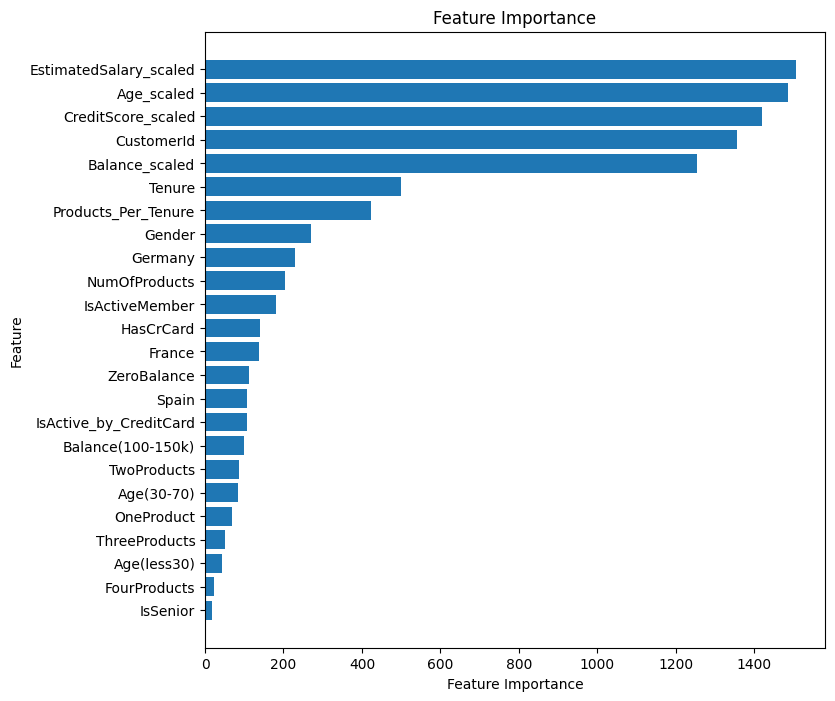

In [96]:
FeatureImp(lgbm)

In [97]:
#Parameters obtained from optuna
xg_best_params = {'lambda': 0.40093945695899574,
 'alpha': 0.003367228970383607,
 'subsample': 0.9015674829231023,
 'colsample_bytree': 0.432988538034984,
 'learning_rate': 0.04678656681603368,
 'n_estimators': 1000,
 'max_depth': 7,
 'min_child_weight': 6,
 'gamma': 0.00021168183130911497}

In [98]:
xg = XGBClassifier(**xg_best_params)

In [99]:
CrossValidate(xg,X,y)

+------+----------+---------+------------------+---------------+
| Fold | Accuracy | Roc_auc | Confusion Matrix | time to train |
+------+----------+---------+------------------+---------------+
|  1   | 0.86586  | 0.88662 |  [[13128   680]  |     43.88     |
|      |          |         |  [ 1668  2028]]  |               |
|  2   |  0.8626  | 0.88716 |  [[13072   736]  |     44.06     |
|      |          |         |  [ 1669  2027]]  |               |
|  3   | 0.86677  | 0.88714 |  [[13098   710]  |     44.21     |
|      |          |         |  [ 1622  2073]]  |               |
|  4   | 0.86465  | 0.88645 |  [[13081   726]  |     44.15     |
|      |          |         |  [ 1643  2053]]  |               |
|  5   | 0.86602  | 0.88722 |  [[13062   745]  |     43.97     |
|      |          |         |  [ 1600  2096]]  |               |
|  6   | 0.86522  | 0.88883 |  [[13101   706]  |     44.49     |
|      |          |         |  [ 1653  2043]]  |               |
|  7   | 0.86454  | 0.885

In [100]:
xg.fit(X,y)

XGBClassifier(alpha=0.003367228970383607, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.432988538034984, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None,
              gamma=0.00021168183130911497, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.40093945695899574, learning_rate=0.04678656681603368,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, ...)

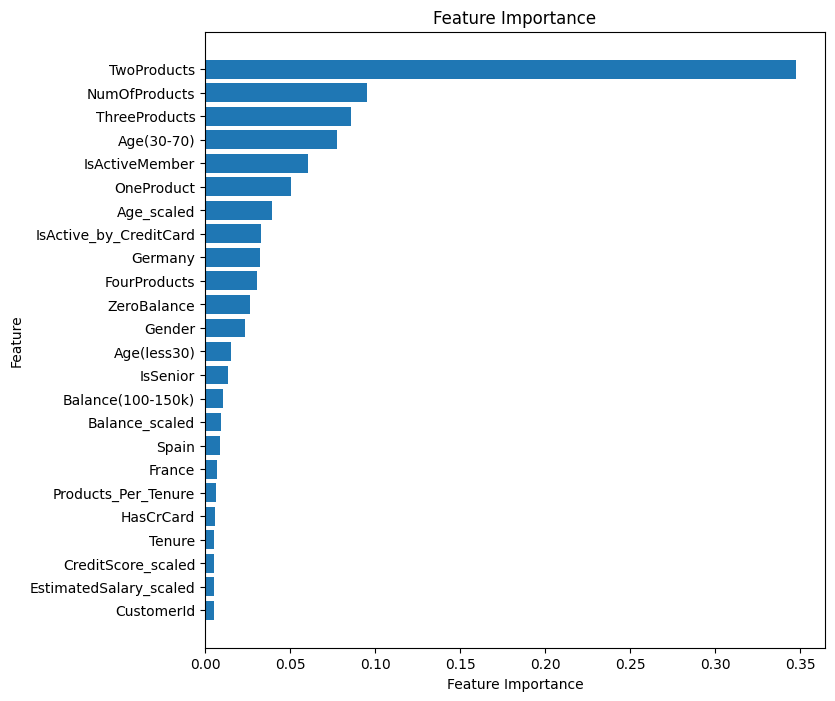

In [101]:
FeatureImp(xg)

In [102]:
clf = CatBoostClassifier(verbose=0)

In [103]:
CrossValidate(clf,X,y)

+------+----------+---------+------------------+---------------+
| Fold | Accuracy | Roc_auc | Confusion Matrix | time to train |
+------+----------+---------+------------------+---------------+
|  1   | 0.86569  | 0.88739 |  [[13147   661]  |     27.52     |
|      |          |         |  [ 1690  2006]]  |               |
|  2   | 0.86306  | 0.88743 |  [[13103   705]  |     27.57     |
|      |          |         |  [ 1692  2004]]  |               |
|  3   | 0.86591  | 0.88645 |  [[13124   684]  |      27.7     |
|      |          |         |  [ 1663  2032]]  |               |
|  4   | 0.86619  | 0.88705 |  [[13119   688]  |     27.27     |
|      |          |         |  [ 1654  2042]]  |               |
|  5   | 0.86774  | 0.88794 |  [[13102   705]  |      27.1     |
|      |          |         |  [ 1610  2086]]  |               |
|  6   | 0.86397  |  0.8888 |  [[13128   679]  |     27.58     |
|      |          |         |  [ 1702  1994]]  |               |
|  7   | 0.86517  | 0.885

In [104]:
clf.fit(X,y)

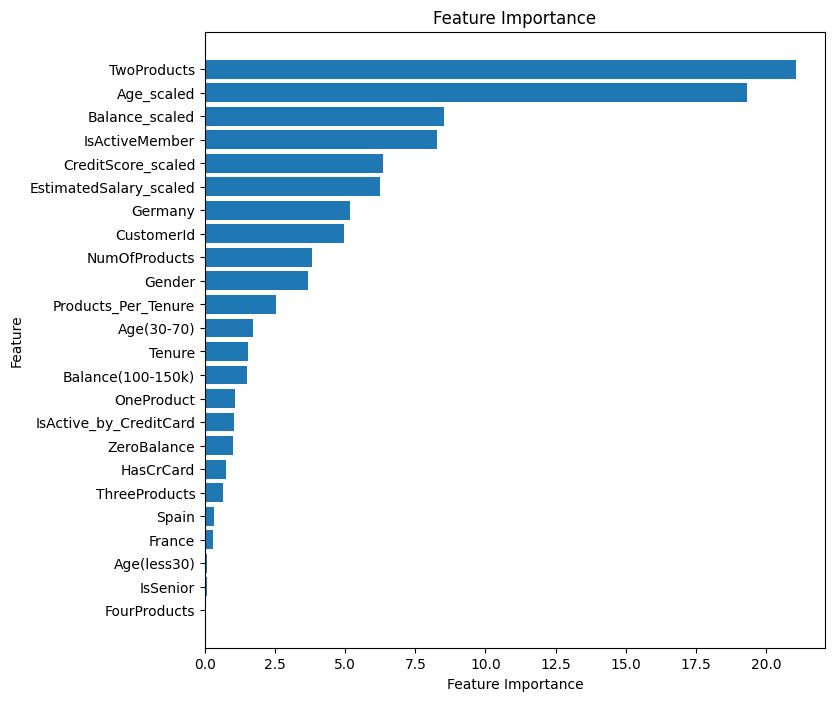

In [105]:
FeatureImp(clf)

In [106]:
voting = VotingClassifier(estimators=[('lgbm',lgbm),('xg',xg),('cat',clf)],voting='soft',weights=[1,2,1])

In [107]:
voting.fit(X,y)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(bagging_fraction=0.4307596104050439,
                                             feature_fraction=0.5658166490064884,
                                             learning_rate=0.07895324521843525,
                                             min_child_samples=10,
                                             num_leaves=100,
                                             reg_alpha=0.0740870606923929,
                                             reg_lambda=2.6993567325444864e-06,
                                             verbose=-1)),
                             ('xg',
                              XGBClassifier(alpha=0.003367228970383607,
                                            base_score=None, booster=None,
                                            call...
                                            learning_rate=0.04678656681603368,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None, min_child_weight=6,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7f28e2307070>)],
                 voting='soft', weights=[1, 2, 1])

In [108]:
def get_sub(model,test):
    preds = model.predict_proba(test)
    x = preds[:,1]
    sub = pd.DataFrame(columns=['id','Exited'])
    sub['id'] = test_id
    sub['Exited'] = x
    return sub  

In [113]:
df_test=df_test[final_cols]

In [114]:
df_test.columns

Index(['CustomerId', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'France', 'Germany', 'Spain', 'OneProduct',
       'TwoProducts', 'ThreeProducts', 'FourProducts', 'ZeroBalance',
       'Balance(100-150k)', 'Age(30-70)', 'Age(less30)', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure'],
      dtype='object')

In [115]:
sub = get_sub(voting,df_test)

In [116]:
sub.head()

,id,Exited
0,165034,0.038876
1,165035,0.837457
2,165036,0.021255
3,165037,0.205281
4,165038,0.381455


In [117]:
sub.to_csv('submission.csv',index=False)